In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
import src.model_train
from imp import reload
reload(src.model_train)

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_squared_log_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from joblib import dump, load

C:\Users\18327\AppData\Local\Temp\ipykernel_1164\3799870607.py:7: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# Data created with data_import.ipynb
data_raw = pd.read_csv('data/data_model.csv')
data = data_raw.copy()

In [15]:
drop_cols = ['ticker', 'Security', 'Headquarters Location', 'Date added', 'CIK', 'Founded',  'target_percent_gain', 'target_direction']
features = [c for c in data.columns if c not in drop_cols]

In [16]:
len(features)

103

In [17]:
X_train, X_test, y_train, y_test = src.model_train.ModelPrepData(
    df=data, features=features, target="target_direction", test_size=0.2
).create_train_test()

In [29]:
pca = PCA(n_components=3)
pca.fit(X_train.iloc[:,8:])

PCA(n_components=3)

In [30]:
pca.explained_variance_ratio_

array([9.99997962e-01, 2.02079098e-06, 1.66345303e-08])

In [31]:
# X_train = pd.concat([X_train.reset_index(drop=True).iloc[:,0:8], pd.DataFrame(pca.transform(X_train.iloc[:,8:])).rename(columns={0:'pca_1', 1:'pca_2', 2:'pca_3'})], axis=1)

In [32]:
# X_test = pd.concat([X_test.reset_index(drop=True).iloc[:,0:8], pd.DataFrame(pca.transform(X_test.iloc[:,8:])).rename(columns={0:'pca_1', 1:'pca_2', 2:'pca_3'})], axis=1)

In [23]:
# opt = src.model_train.CreateModel(X_train, X_test, y_train, y_test, task='classification', model_type='LGBM').hpo()

In [18]:
clf_model = src.model_train.CreateModel(X_train, X_test, y_train, y_test, task='classification', model_type='LGBM').fit()

[LightGBM] [Info] Number of positive: 221128, number of negative: 193365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23349
[LightGBM] [Info] Number of data points in the train set: 414493, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533490 -> initscore=0.134162
[LightGBM] [Info] Start training from score 0.134162


In [14]:
dump(clf_model, f'models/candidate_models/lgbm-direction-classifier-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.joblib') 

['models/candidate_models/lgbm-direction-classifier-2024-05-13-19-23-24.joblib']

In [19]:
preds_proba = clf_model.predict_proba(X_test)

In [20]:
def custom_predict(probas, threshold):
    return (probas[:, 1] >= threshold).astype(int)

In [21]:
preds = custom_predict(preds_proba, 0.51)

In [22]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.53      0.58     48582
           1       0.64      0.75      0.69     55042

    accuracy                           0.65    103624
   macro avg       0.65      0.64      0.64    103624
weighted avg       0.65      0.65      0.64    103624



In [14]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.67      0.49      0.56     48534
           1       0.63      0.78      0.70     55090

    accuracy                           0.65    103624
   macro avg       0.65      0.64      0.63    103624
weighted avg       0.65      0.65      0.64    103624



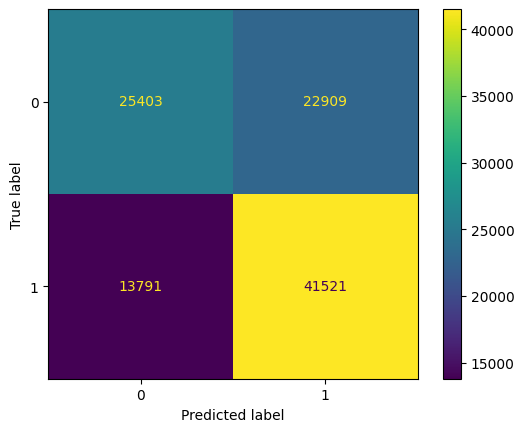

In [11]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_model.classes_)
disp.plot()

In [12]:
result = pd.concat([y_test.reset_index(drop=True), pd.Series(preds, name='predicted_values')], axis=1)
result

,target_direction,predicted_values
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0
...,...,...
103619,1,1
103620,0,1
103621,1,1
103622,1,1


In [13]:
# Get the LightGBM estimator from the pipeline
lgb_model = clf_model.named_steps['classification']

# Get feature importance from the LightGBM estimator
feature_importance = lgb_model.feature_importances_

# Get the names of the features
feature_names = clf_model.named_steps['preprocessor'].transformers_[0][2]

# Create a DataFrame to store feature importance with feature names
df_feature_importance = pd.DataFrame(sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True), columns=['Feature', 'Importance'])
df_feature_importance.sort_values('Importance', ascending=False).head(10)

,Feature,Importance
0,WM2NS,376
1,NASDAQCOM,343
2,DGS10,268
3,MSPNHSUS,203
4,HSN1F,170
5,UMCSENT,163
6,FEDFUNDS,150
7,UNRATE,146
8,month,107
9,CP,102
